In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No EMA LSTM Time Series - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-Cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4106, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[0.03424644, 0.46282749, 0.22432246],
       [0.31506791, 0.32255128, 0.49006783],
       [0.        , 0.        , 0.17891161],
       [0.28082311, 0.19881152, 0.55203919],
       [0.73972344, 0.52369458, 0.85164683],
       [0.52739485, 0.37337444, 0.46466227],
       [0.15068401, 0.10667825, 0.19175134],
       [0.14383571, 0.12955741, 0.05083703],
       [0.26712158, 0.33580412, 0.17165809],
       [0.16438226, 0.3783434 , 0.        ],
       [0.58904107, 0.83077978, 0.30402389],
       [0.85616429, 1.        , 0.89587626],
       [0.5068483 , 0.60041228, 0.66894449],
       [1.        , 0.93732045, 1.        ],
       [0.17808379, 0.04412728, 0.39220808]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4106,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 2s 73ms/step - loss: 0.2952 - accuracy: 0.5037 - mse: 0.4611 - weighted_accuracy: 0.3401 - weighted_mse: 0.5242 - val_loss: 0.3016 - val_accuracy: 0.0450 - val_mse: 0.3464 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3464
Epoch 2/200
26/26 [==============================] - 0s 16ms/step - loss: 0.2209 - accuracy: 0.3590 - mse: 0.7114 - weighted_accuracy: 0.4254 - weighted_mse: 0.7151 - val_loss: 0.2939 - val_accuracy: 0.0450 - val_mse: 0.3706 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3706
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1971 - accuracy: 0.2884 - mse: 0.9292 - weighted_accuracy: 0.4661 - weighted_mse: 0.9114 - val_loss: 0.2847 - val_accuracy: 0.0450 - val_mse: 0.4032 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4032
Epoch 4/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1853 - accuracy: 0.2667 - mse: 1.0702 - weighted_accuracy: 0.5078 - weight

26/26 [==============================] - 0s 9ms/step - loss: 0.1377 - accuracy: 0.3840 - mse: 1.6755 - weighted_accuracy: 0.7035 - weighted_mse: 1.5757 - val_loss: 0.1892 - val_accuracy: 0.3710 - val_mse: 1.3926 - val_weighted_accuracy: 0.3710 - val_weighted_mse: 1.3926
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1368 - accuracy: 0.3803 - mse: 1.6934 - weighted_accuracy: 0.7109 - weighted_mse: 1.5981 - val_loss: 0.1831 - val_accuracy: 0.3917 - val_mse: 1.4566 - val_weighted_accuracy: 0.3917 - val_weighted_mse: 1.4566
Epoch 31/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1355 - accuracy: 0.4157 - mse: 1.6730 - weighted_accuracy: 0.7194 - weighted_mse: 1.5826 - val_loss: 0.1950 - val_accuracy: 0.3187 - val_mse: 1.5755 - val_weighted_accuracy: 0.3187 - val_weighted_mse: 1.5755
Epoch 32/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1343 - accuracy: 0.4090 - mse: 1.7140 - weighted_accuracy: 0.7278 - weighted_mse: 1

Epoch 58/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1094 - accuracy: 0.5743 - mse: 2.2015 - weighted_accuracy: 0.8205 - weighted_mse: 2.1682 - val_loss: 0.1803 - val_accuracy: 0.4903 - val_mse: 2.1368 - val_weighted_accuracy: 0.4903 - val_weighted_mse: 2.1368
Epoch 59/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1086 - accuracy: 0.5828 - mse: 2.1913 - weighted_accuracy: 0.8194 - weighted_mse: 2.1623 - val_loss: 0.1752 - val_accuracy: 0.4866 - val_mse: 2.2313 - val_weighted_accuracy: 0.4866 - val_weighted_mse: 2.2313
Epoch 60/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1090 - accuracy: 0.5953 - mse: 2.2165 - weighted_accuracy: 0.8240 - weighted_mse: 2.1842 - val_loss: 0.1774 - val_accuracy: 0.5012 - val_mse: 2.2570 - val_weighted_accuracy: 0.5012 - val_weighted_mse: 2.2570
Epoch 61/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1078 - accuracy: 0.5710 - mse: 2.2490 - weighted_accuracy: 0.8237 - we

Epoch 87/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0855 - accuracy: 0.6940 - mse: 2.9940 - weighted_accuracy: 0.8729 - weighted_mse: 3.0493 - val_loss: 0.1507 - val_accuracy: 0.6582 - val_mse: 3.0183 - val_weighted_accuracy: 0.6582 - val_weighted_mse: 3.0183
Epoch 88/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0858 - accuracy: 0.7195 - mse: 3.0166 - weighted_accuracy: 0.8779 - weighted_mse: 3.0752 - val_loss: 0.1703 - val_accuracy: 0.5876 - val_mse: 3.0052 - val_weighted_accuracy: 0.5876 - val_weighted_mse: 3.0052
Epoch 89/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 0.7138 - mse: 3.0288 - weighted_accuracy: 0.8844 - weighted_mse: 3.0967 - val_loss: 0.1372 - val_accuracy: 0.7129 - val_mse: 3.1251 - val_weighted_accuracy: 0.7129 - val_weighted_mse: 3.1251
Epoch 90/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0831 - accuracy: 0.7220 - mse: 3.0753 - weighted_accuracy: 0.8832 - weig

Epoch 116/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0652 - accuracy: 0.7923 - mse: 4.1343 - weighted_accuracy: 0.9175 - weighted_mse: 4.1364 - val_loss: 0.1470 - val_accuracy: 0.7105 - val_mse: 4.1401 - val_weighted_accuracy: 0.7105 - val_weighted_mse: 4.1401
Epoch 117/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0654 - accuracy: 0.8018 - mse: 4.1998 - weighted_accuracy: 0.9188 - weighted_mse: 4.2252 - val_loss: 0.1607 - val_accuracy: 0.6946 - val_mse: 4.5194 - val_weighted_accuracy: 0.6946 - val_weighted_mse: 4.5194
Epoch 118/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0634 - accuracy: 0.8015 - mse: 4.2615 - weighted_accuracy: 0.9230 - weighted_mse: 4.2660 - val_loss: 0.1501 - val_accuracy: 0.7214 - val_mse: 4.6845 - val_weighted_accuracy: 0.7214 - val_weighted_mse: 4.6845
Epoch 119/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0634 - accuracy: 0.8009 - mse: 4.2787 - weighted_accuracy: 0.920

Epoch 145/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0487 - accuracy: 0.8669 - mse: 5.7691 - weighted_accuracy: 0.9470 - weighted_mse: 5.6025 - val_loss: 0.1562 - val_accuracy: 0.7421 - val_mse: 5.8800 - val_weighted_accuracy: 0.7421 - val_weighted_mse: 5.8800
Epoch 146/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0473 - accuracy: 0.8758 - mse: 5.7902 - weighted_accuracy: 0.9523 - weighted_mse: 5.6093 - val_loss: 0.1824 - val_accuracy: 0.6873 - val_mse: 5.7740 - val_weighted_accuracy: 0.6873 - val_weighted_mse: 5.7740
Epoch 147/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0464 - accuracy: 0.8584 - mse: 5.8823 - weighted_accuracy: 0.9482 - weighted_mse: 5.7494 - val_loss: 0.1480 - val_accuracy: 0.7859 - val_mse: 6.7210 - val_weighted_accuracy: 0.7859 - val_weighted_mse: 6.7210
Epoch 148/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0492 - accuracy: 0.8672 - mse: 5.8901 - weighted_accuracy: 0.942

Epoch 174/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0369 - accuracy: 0.9093 - mse: 7.5904 - weighted_accuracy: 0.9582 - weighted_mse: 7.0652 - val_loss: 0.1740 - val_accuracy: 0.7701 - val_mse: 7.9025 - val_weighted_accuracy: 0.7701 - val_weighted_mse: 7.9025
Epoch 175/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0358 - accuracy: 0.9108 - mse: 7.7001 - weighted_accuracy: 0.9652 - weighted_mse: 7.2230 - val_loss: 0.1920 - val_accuracy: 0.7470 - val_mse: 7.8385 - val_weighted_accuracy: 0.7470 - val_weighted_mse: 7.8385
Epoch 176/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0368 - accuracy: 0.9068 - mse: 7.5805 - weighted_accuracy: 0.9637 - weighted_mse: 7.0402 - val_loss: 0.1708 - val_accuracy: 0.7762 - val_mse: 7.8791 - val_weighted_accuracy: 0.7762 - val_weighted_mse: 7.8791
Epoch 177/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0371 - accuracy: 0.9074 - mse: 7.7852 - weighted_accuracy: 0.961

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1897123157978058
Test accuracy: 0.7968369722366333


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.5164194e+00 -3.6059786e-03  3.3238131e-01]
 [-2.8163218e+00 -7.2486562e-01 -5.3084749e-01]
 [-2.6617348e+00 -2.5143263e+00  2.0020113e+00]
 ...
 [-5.1658006e+00 -5.5126410e+00  5.4180646e+00]
 [-1.2473378e+00 -4.2416801e+00  4.4985959e-01]
 [-3.4638553e+00 -2.1283638e+00  1.0116218e+00]]


Counter({2: 707, 1: 59, 0: 56})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 30
actual sells but predicted buy: 4
actual predicted sells: 2
actual sells but predicted hold: 31
actual holds but predicted buy: 48
actual holds but predicted sell: 54
actual predicted holds: 646
Percentage buys correct: 18.91891891891892%
Percentage sells correct: 5.405405405405405%
Percentage holds correct: 86.36363636363636%
actual buys: 37
actual sells: 37
actual holds: 748


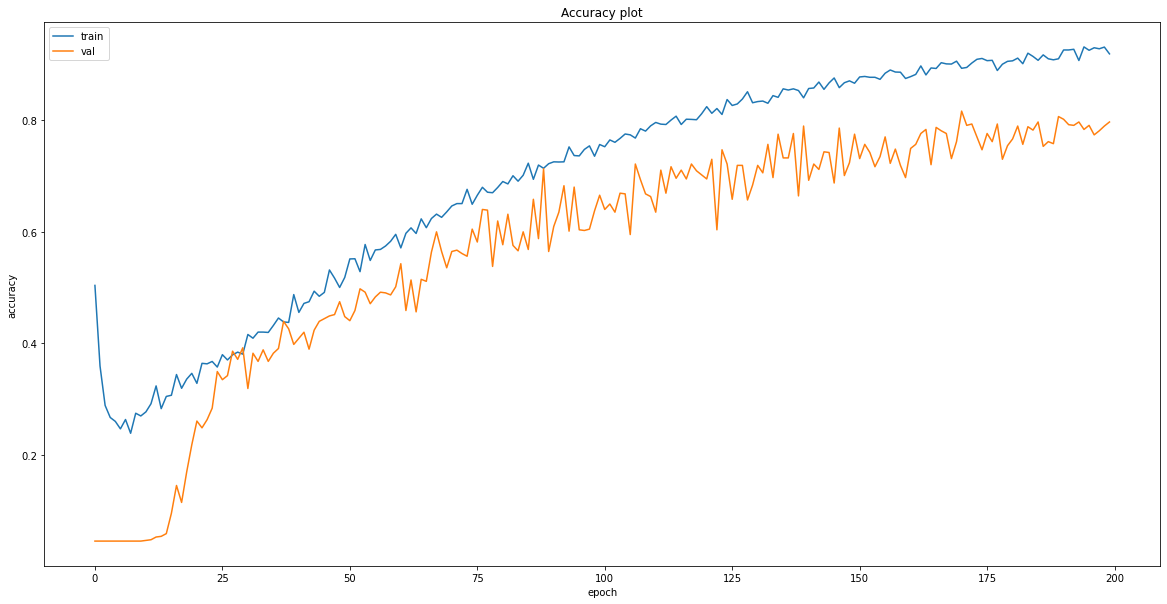

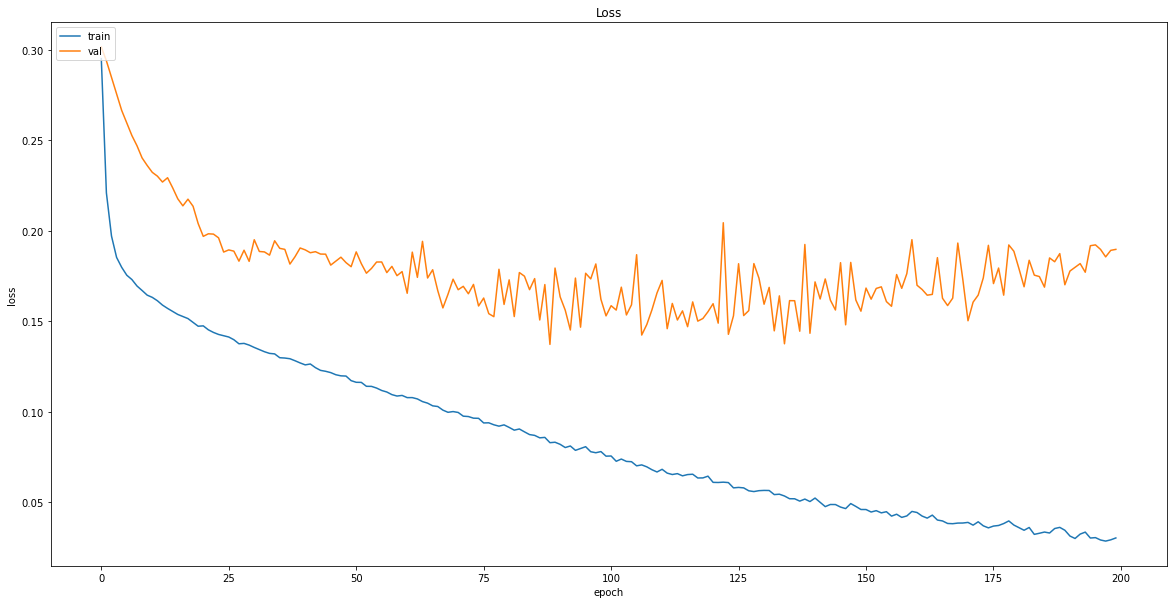

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_no_ema.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [26]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.7923 - mean_squared_error: 12.3938 - weighted_accuracy: 0.7923 - weighted_mean_squared_error: 12.3938
Test loss: 0.19486860930919647
Test accuracy: 0.7922705411911011


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 0: 19, 1: 14})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [33]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [34]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-15,724.780029,700.682442,-8.071529,46243699.0,2.0,2,2
2019-02-18,740.000000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.760010,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.000000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.250000,714.454318,-29.824573,40956103.0,2.0,2,2


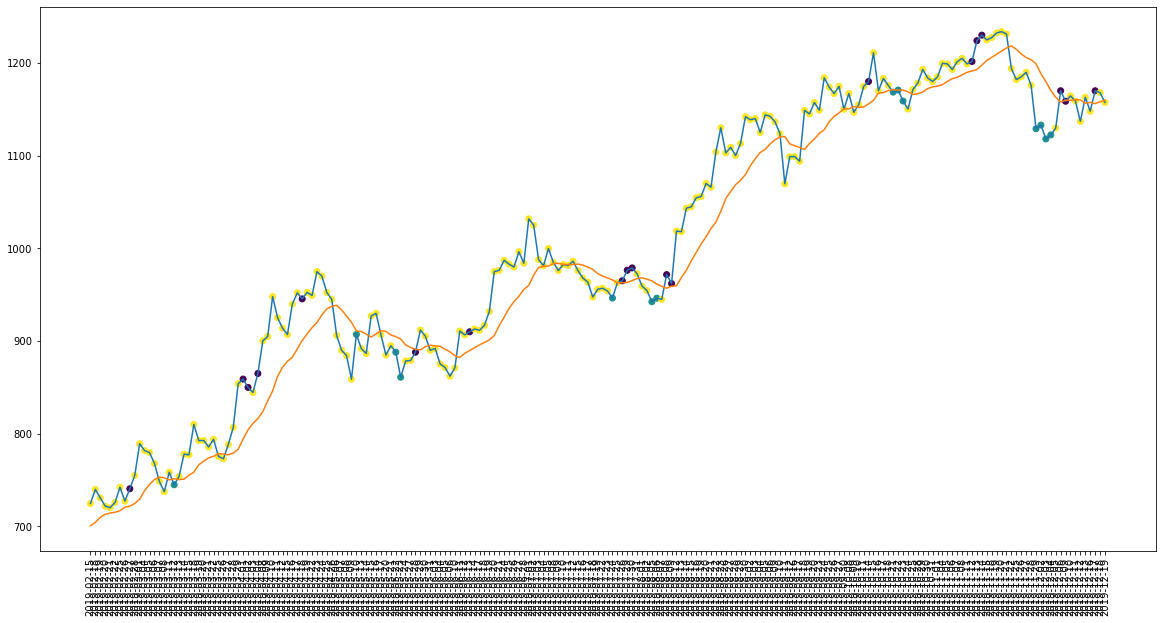

In [35]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 16
actual predicted holds: 158
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 85.4054054054054%
actual buys: 11
actual sells: 11
actual holds: 185


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 724.780029296875, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438]
[727.3499755859375, 740.7000122070312, 742.3300170898438, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 47.36842105263158%
Percentage holds correct: 86.7816091954023%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $745.010009765625
Shares owned at the moment: 13
Cash capital at the moment: $288.2357651977545


Price increase from previously bought: 14.984257545945102%
Share price: $859.0
Shares owned at the moment: 0
Cash capital at the moment: $11424.526515197755


Share price: $907.1199951171876
Shares owned at the moment: 12
Cash capital at the moment: $509.15161395263567


Stop Loss Activated!

Share price: $861.0
Shares owned at the moment: 0
Cash capital at the moment: $10812.738613952635


Share price: $861.0
Shares owned at the moment: 12
Cash capital at the moment: $452.32561395263474


Price increase from previously bought: 5.40120360066727%
Share price: $910.0
Shares owned at the moment: 0
Cash capital at the moment: $11342.295613952634


Share price: $946.3599853515624
Shares owned at the moment: 11
Cash capital at the moment: $903.7083855285637


Price increase from previously bought: 24.34632882748453%
Share price: $1180.0
Shares owned at the moment: 0
Cash capital at 

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15556.77199960327
profit gained: 55.56771999603271%


In [40]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%


### Recession

In [41]:
logger = []

In [42]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [43]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [44]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [45]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [47]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.8125 - mean_squared_error: 11.0491 - weighted_accuracy: 0.8125 - weighted_mean_squared_error: 11.0491
Test loss: 0.16061526536941528
Test accuracy: 0.8125


In [48]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 0: 20, 1: 5})

In [49]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [50]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [51]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-18,1084.000000,1082.243470,-14.989967,2243205.0,2.0,2,2
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,0,0
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,2
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2


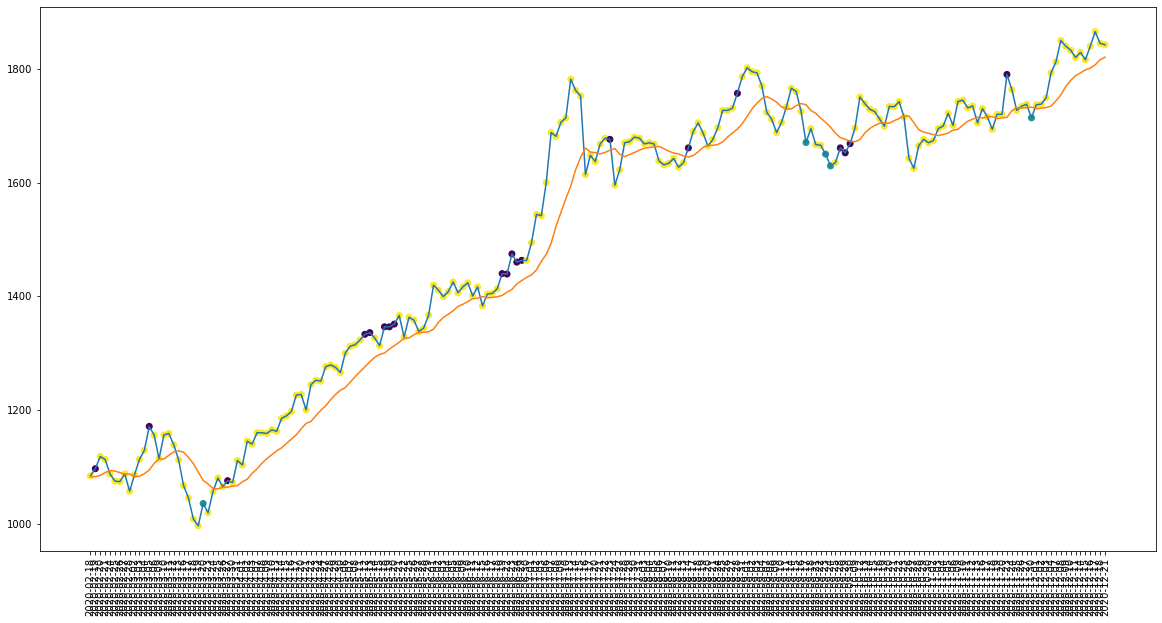

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 4
actual holds but predicted sell: 18
actual predicted holds: 167
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.0%
Percentage holds correct: 88.35978835978835%
actual buys: 9
actual sells: 10
actual holds: 189


In [54]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1084.0, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1073.699951171875, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1171.0]
Percentage buys correct: 100.0%
Percentage sells correct: 50.0%
Percentage holds correct: 85.24590163934427%


In [55]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1035.280029296875
Shares owned at the moment: 9
Cash capital at the moment: $656.8565556030262


Price increase from previously bought: 28.40432207208088%
Share price: $1333.0
Shares owned at the moment: 0
Cash capital at the moment: $12620.864805603025


Share price: $1670.52001953125
Shares owned at the moment: 7
Cash capital at the moment: $895.0671585082982


Price increase from previously bought: 6.870936235774061%
Share price: $1790.2099609375
Shares owned at the moment: 0
Cash capital at the moment: $13392.075343322751


Share price: $1713.9100341796875
Shares owned at the moment: 7
Cash capital at the moment: $1361.7123359069792




Capital at the end of test period: $14223.744210906978
profit gained: 42.237442109069775%


In [56]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16754.069125
profit gained: 67.54069125000002%


In [57]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%


### Midea Group

In [58]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [59]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [60]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(1253, 15, 3)

In [63]:
y = labels
y = np.array(y)

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 97ms/step - loss: 0.3167 - accuracy: 0.5309 - mse: 0.3788 - weighted_accuracy: 0.3378 - weighted_mse: 0.4580 - val_loss: 0.3038 - val_accuracy: 0.0558 - val_mse: 0.3401 - val_weighted_accuracy: 0.0558 - val_weighted_mse: 0.3401
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2720 - accuracy: 0.5170 - mse: 0.4528 - weighted_accuracy: 0.3800 - weighted_mse: 0.5064 - val_loss: 0.3030 - val_accuracy: 0.0598 - val_mse: 0.3428 - val_weighted_accuracy: 0.0598 - val_weighted_mse: 0.3428
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2444 - accuracy: 0.4701 - mse: 0.5362 - weighted_accuracy: 0.4673 - weighted_mse: 0.5640 - val_loss: 0.3011 - val_accuracy: 0.0558 - val_mse: 0.3444 - val_weighted_accuracy: 0.0558 - val_weighted_mse: 0.3444
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2238 - accuracy: 0.4212 - mse: 0.6169 - weighted_accuracy: 0.4978 - weighted_mse: 0

8/8 [==============================] - 0s 8ms/step - loss: 0.1371 - accuracy: 0.4990 - mse: 1.2568 - weighted_accuracy: 0.7667 - weighted_mse: 1.2333 - val_loss: 0.2041 - val_accuracy: 0.2829 - val_mse: 0.6909 - val_weighted_accuracy: 0.2829 - val_weighted_mse: 0.6909
Epoch 31/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1358 - accuracy: 0.4990 - mse: 1.2612 - weighted_accuracy: 0.7614 - weighted_mse: 1.2327 - val_loss: 0.1995 - val_accuracy: 0.4303 - val_mse: 0.7083 - val_weighted_accuracy: 0.4303 - val_weighted_mse: 0.7083
Epoch 32/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1342 - accuracy: 0.5170 - mse: 1.2628 - weighted_accuracy: 0.7722 - weighted_mse: 1.2455 - val_loss: 0.1954 - val_accuracy: 0.5179 - val_mse: 0.7256 - val_weighted_accuracy: 0.5179 - val_weighted_mse: 0.7256
Epoch 33/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1329 - accuracy: 0.5020 - mse: 1.2774 - weighted_accuracy: 0.7614 - weighted_mse: 1.2464 - va

8/8 [==============================] - 0s 8ms/step - loss: 0.1038 - accuracy: 0.6407 - mse: 1.5444 - weighted_accuracy: 0.8543 - weighted_mse: 1.5104 - val_loss: 0.1228 - val_accuracy: 0.8526 - val_mse: 1.2224 - val_weighted_accuracy: 0.8526 - val_weighted_mse: 1.2224
Epoch 60/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1028 - accuracy: 0.6627 - mse: 1.5394 - weighted_accuracy: 0.8559 - weighted_mse: 1.5199 - val_loss: 0.1230 - val_accuracy: 0.8446 - val_mse: 1.2104 - val_weighted_accuracy: 0.8446 - val_weighted_mse: 1.2104
Epoch 61/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1007 - accuracy: 0.6657 - mse: 1.5397 - weighted_accuracy: 0.8699 - weighted_mse: 1.5202 - val_loss: 0.1229 - val_accuracy: 0.8446 - val_mse: 1.2016 - val_weighted_accuracy: 0.8446 - val_weighted_mse: 1.2016
Epoch 62/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1016 - accuracy: 0.6737 - mse: 1.5685 - weighted_accuracy: 0.8599 - weighted_mse: 1.5380 - va

8/8 [==============================] - 0s 9ms/step - loss: 0.0772 - accuracy: 0.7685 - mse: 2.0052 - weighted_accuracy: 0.9075 - weighted_mse: 1.9878 - val_loss: 0.1422 - val_accuracy: 0.6733 - val_mse: 1.8201 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 1.8201
Epoch 89/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0783 - accuracy: 0.7715 - mse: 2.0167 - weighted_accuracy: 0.9162 - weighted_mse: 1.9752 - val_loss: 0.1378 - val_accuracy: 0.6932 - val_mse: 1.8386 - val_weighted_accuracy: 0.6932 - val_weighted_mse: 1.8386
Epoch 90/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0792 - accuracy: 0.7824 - mse: 2.0443 - weighted_accuracy: 0.9127 - weighted_mse: 2.0177 - val_loss: 0.1396 - val_accuracy: 0.6932 - val_mse: 1.9762 - val_weighted_accuracy: 0.6932 - val_weighted_mse: 1.9762
Epoch 91/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0746 - accuracy: 0.7715 - mse: 2.0824 - weighted_accuracy: 0.9162 - weighted_mse: 2.0521 - va

8/8 [==============================] - 0s 9ms/step - loss: 0.0573 - accuracy: 0.8483 - mse: 2.7562 - weighted_accuracy: 0.9379 - weighted_mse: 2.6655 - val_loss: 0.1521 - val_accuracy: 0.7291 - val_mse: 2.8424 - val_weighted_accuracy: 0.7291 - val_weighted_mse: 2.8424
Epoch 118/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0564 - accuracy: 0.8453 - mse: 2.7883 - weighted_accuracy: 0.9433 - weighted_mse: 2.7059 - val_loss: 0.1543 - val_accuracy: 0.7331 - val_mse: 2.9777 - val_weighted_accuracy: 0.7331 - val_weighted_mse: 2.9777
Epoch 119/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0552 - accuracy: 0.8423 - mse: 2.8181 - weighted_accuracy: 0.9422 - weighted_mse: 2.7023 - val_loss: 0.1524 - val_accuracy: 0.7131 - val_mse: 2.8621 - val_weighted_accuracy: 0.7131 - val_weighted_mse: 2.8621
Epoch 120/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0564 - accuracy: 0.8533 - mse: 2.8533 - weighted_accuracy: 0.9462 - weighted_mse: 2.7588

Epoch 146/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0416 - accuracy: 0.8792 - mse: 3.6714 - weighted_accuracy: 0.9557 - weighted_mse: 3.4515 - val_loss: 0.1698 - val_accuracy: 0.7849 - val_mse: 4.2309 - val_weighted_accuracy: 0.7849 - val_weighted_mse: 4.2309
Epoch 147/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0409 - accuracy: 0.8892 - mse: 3.7183 - weighted_accuracy: 0.9594 - weighted_mse: 3.4772 - val_loss: 0.1586 - val_accuracy: 0.7888 - val_mse: 4.1369 - val_weighted_accuracy: 0.7888 - val_weighted_mse: 4.1369
Epoch 148/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0410 - accuracy: 0.8962 - mse: 3.8192 - weighted_accuracy: 0.9619 - weighted_mse: 3.4901 - val_loss: 0.1626 - val_accuracy: 0.8088 - val_mse: 4.4911 - val_weighted_accuracy: 0.8088 - val_weighted_mse: 4.4911
Epoch 149/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0389 - accuracy: 0.8972 - mse: 3.8827 - weighted_accuracy: 0.9623 - weighte

Epoch 175/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0306 - accuracy: 0.9132 - mse: 4.9787 - weighted_accuracy: 0.9682 - weighted_mse: 4.4442 - val_loss: 0.1957 - val_accuracy: 0.7809 - val_mse: 5.9294 - val_weighted_accuracy: 0.7809 - val_weighted_mse: 5.9294
Epoch 176/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0298 - accuracy: 0.9182 - mse: 5.0299 - weighted_accuracy: 0.9700 - weighted_mse: 4.4742 - val_loss: 0.1986 - val_accuracy: 0.7888 - val_mse: 5.5359 - val_weighted_accuracy: 0.7888 - val_weighted_mse: 5.5359
Epoch 177/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0296 - accuracy: 0.9232 - mse: 5.1092 - weighted_accuracy: 0.9718 - weighted_mse: 4.4331 - val_loss: 0.1930 - val_accuracy: 0.7928 - val_mse: 5.4636 - val_weighted_accuracy: 0.7928 - val_weighted_mse: 5.4636
Epoch 178/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0285 - accuracy: 0.9251 - mse: 5.1849 - weighted_accuracy: 0.9726 - weighte

In [69]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.20920781791210175
Test accuracy: 0.7768924236297607


In [70]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.162832   -3.416947    2.8045309 ]
 [-0.22040087 -2.1205642  -1.1789004 ]
 [-2.0894039  -1.0531415   0.64681894]
 [-2.4797015  -0.509064   -0.5047055 ]
 [-1.4018039  -1.4756025  -0.4442709 ]
 [-1.1346737  -2.0773115   0.39657116]
 [-3.9082806  -2.119481    1.2878823 ]
 [-1.2323432  -1.7842382  -0.95618415]
 [-0.5951624  -2.3844535  -0.05520511]
 [-1.0075788  -4.340061    0.32842648]
 [ 0.03955713 -3.5511346   0.01556613]
 [-2.077686   -3.058525    1.1645248 ]
 [-2.3697786  -4.1662097   1.9029227 ]
 [-3.5112953  -4.0784774   3.3644855 ]
 [-1.3820593  -4.0711727   1.3123554 ]
 [-2.787436   -5.4902234   2.570711  ]
 [-3.35806    -0.81190336  0.13861735]
 [-0.6193905  -2.1993928  -0.10279839]
 [-3.0071106  -3.0215166   2.0519345 ]
 [-1.7181866  -2.4095345   1.3384098 ]
 [-2.7643075  -2.2297873   1.3595862 ]
 [-0.45473754 -1.0281309  -1.2882493 ]
 [-2.6575823  -2.6186936   1.3703476 ]
 [-1.3928779  -1.0107448  -0.518495  ]
 [ 1.8744022  -3.876271   -2.2638392 ]
 [-3.3682952  -1.5424309 

Counter({2: 216, 0: 16, 1: 19})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [72]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 18
actual holds but predicted sell: 16
actual predicted holds: 194
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 0.0%
Percentage holds correct: 85.08771929824562%
actual buys: 13
actual sells: 10
actual holds: 228


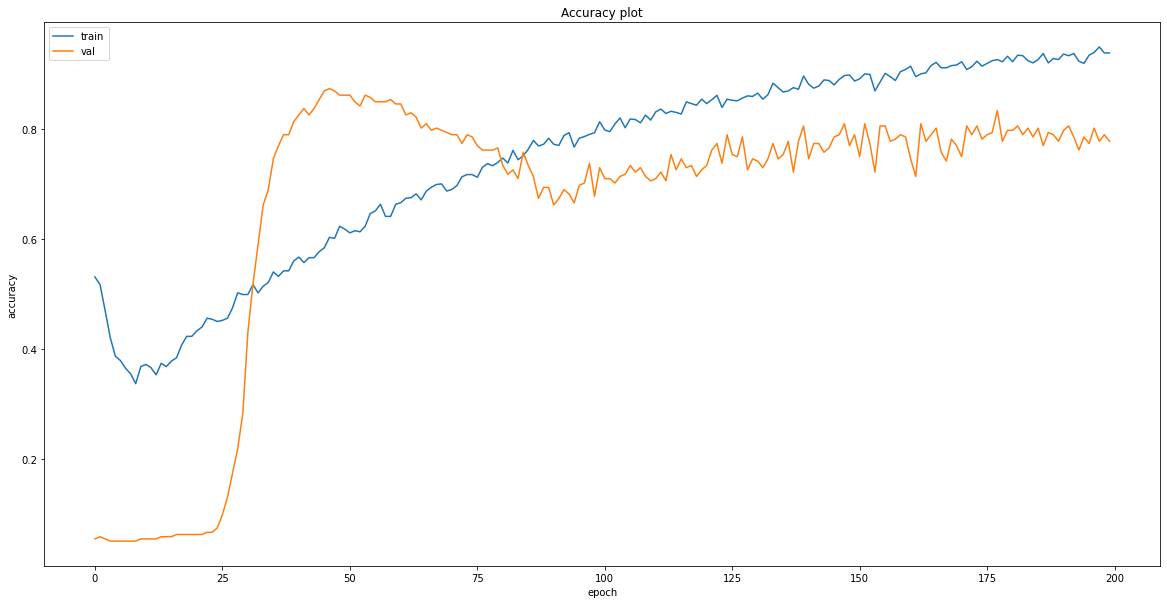

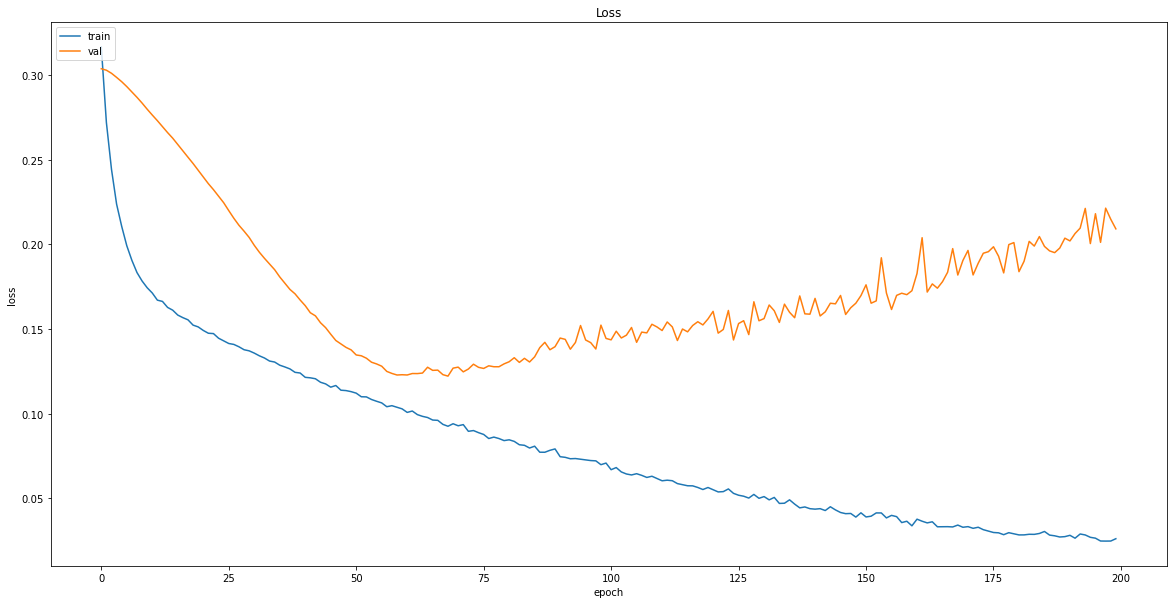

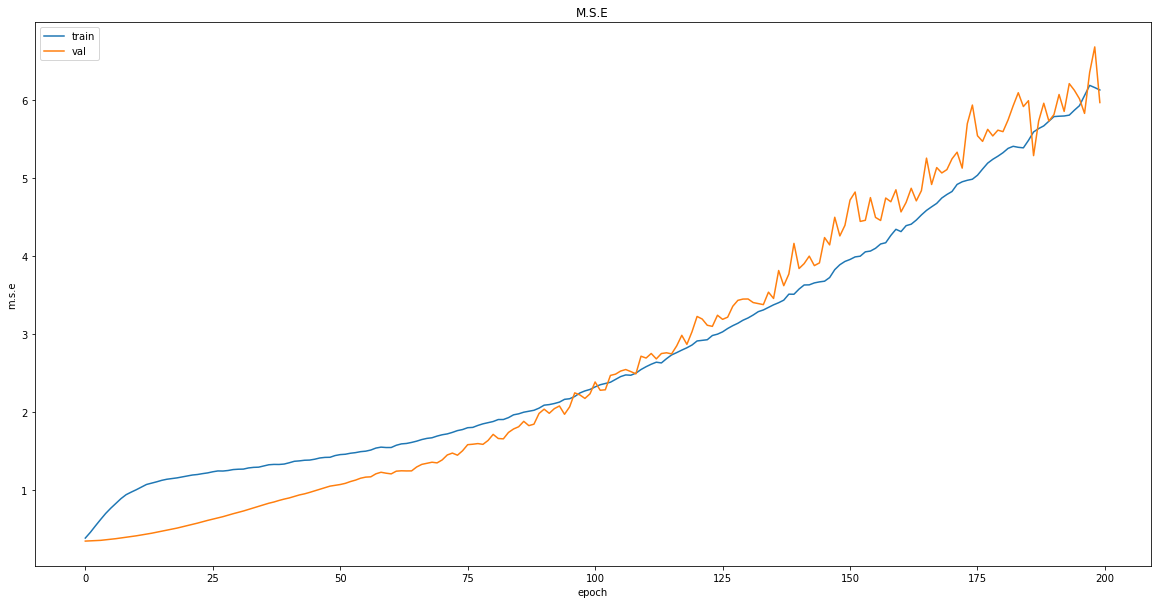

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [75]:
logger = []

In [76]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [77]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [81]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1940 - accuracy: 0.7826 - mean_squared_error: 5.5502 - weighted_accuracy: 0.7826 - weighted_mean_squared_error: 5.5502
Test loss: 0.19402700662612915
Test accuracy: 0.782608687877655


In [82]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 20, 2: 172, 0: 15})

In [83]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [84]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [85]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,1,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,1,2


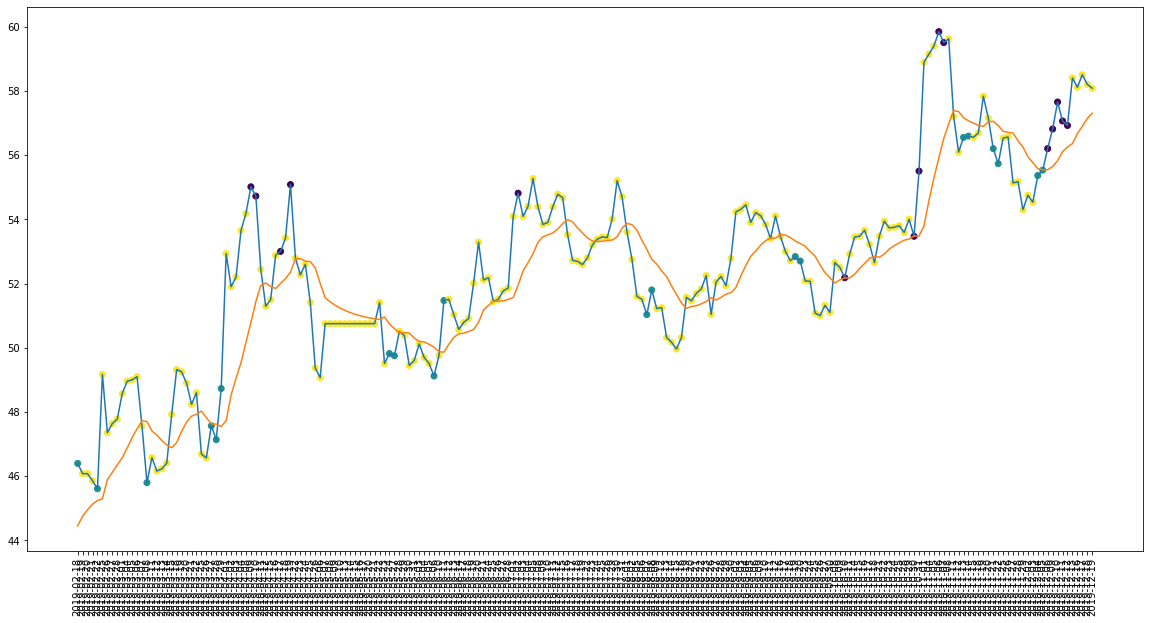

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

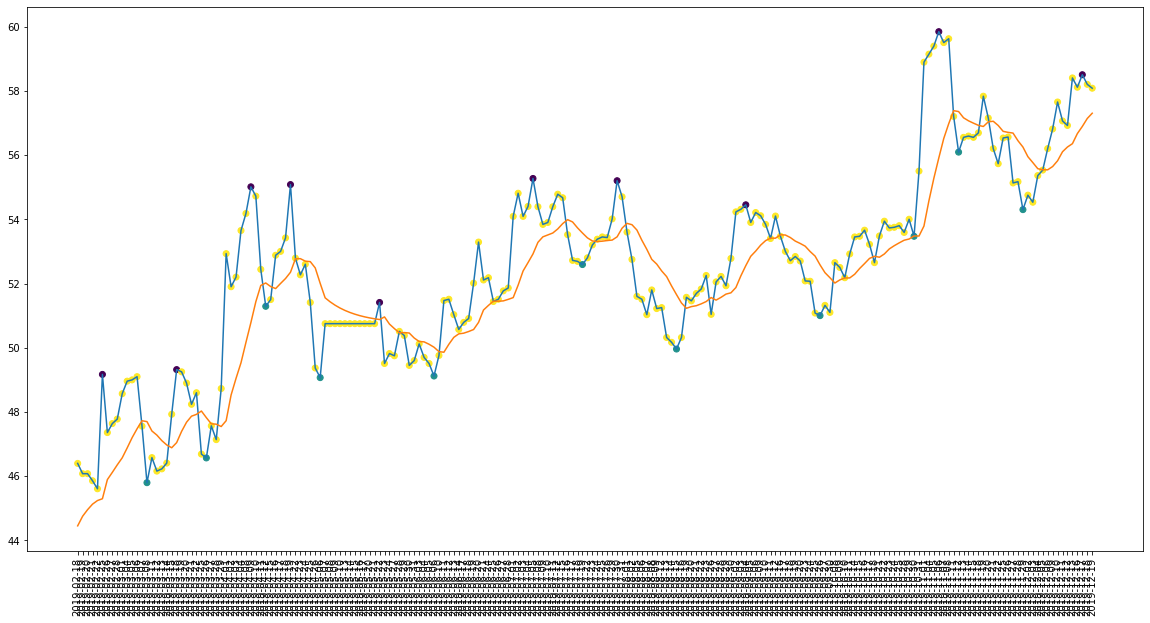

In [87]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 18
actual holds but predicted sell: 11
actual predicted holds: 157
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 30.0%
Percentage holds correct: 84.40860215053763%
actual buys: 11
actual sells: 10
actual holds: 186


In [89]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 60.0%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 79.53216374269006%


In [90]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.4000015258789
Shares owned at the moment: 214
Cash capital at the moment: $43.0932725639359


Price increase from previously bought: 18.230892013582924%
Share price: $55.0099983215332
Shares owned at the moment: 0
Cash capital at the moment: $11782.85952935982


Share price: $49.81999969482422
Shares owned at the moment: 235
Cash capital at the moment: $42.96342627334707


Price increase from previously bought: 9.71434678486711%
Share price: $54.81000137329102
Shares owned at the moment: 0
Cash capital at the moment: $12887.892785609249


Share price: $51.02999877929688
Shares owned at the moment: 251
Cash capital at the moment: $44.13963534832146


Price increase from previously bought: 8.461287265685225%
Share price: $55.5
Shares owned at the moment: 0
Cash capital at the moment: $13936.33076034832


Share price: $56.54999923706055
Shares owned at the moment: 245
Cash capital at the moment: $43.48038528251709


Stop Loss Activated!

Share price: $54.29999923706055
Sh

In [91]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [92]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%
2,0.782609,18.181818181818183%,30.0%,84.40860215053763%,60.0%,53.333333333333336%,79.53216374269006%,38.859174240198136%,24.380335833320625%


### recession

In [93]:
logger = []

In [94]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


In [95]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [96]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [97]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [98]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1852 - accuracy: 0.7260 - mean_squared_error: 5.8177 - weighted_accuracy: 0.7260 - weighted_mean_squared_error: 5.8177
Test loss: 0.1852468103170395
Test accuracy: 0.7259615659713745


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 1: 21, 0: 27})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [102]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


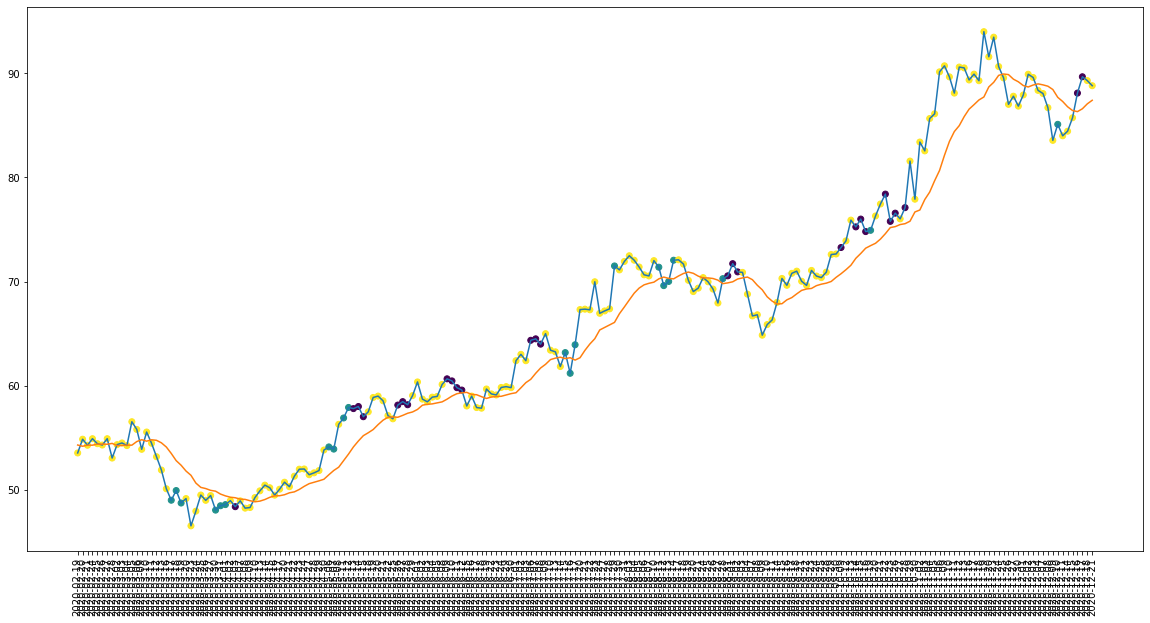

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

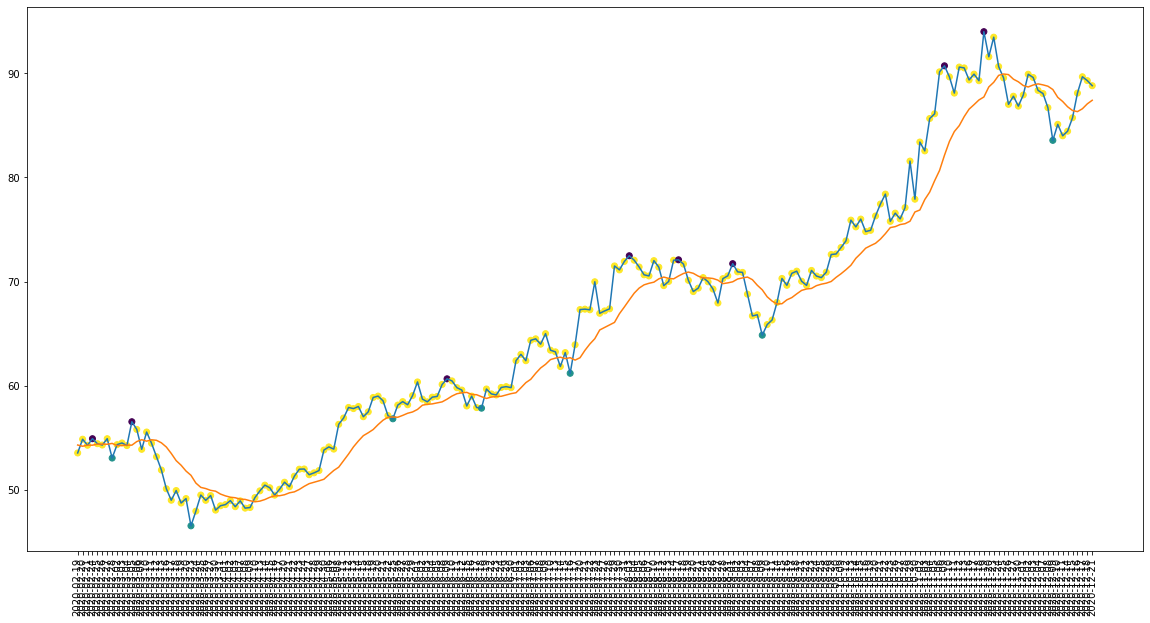

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 25
actual predicted holds: 148
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 25.0%
Percentage holds correct: 76.6839378238342%
actual buys: 7
actual sells: 8
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 59.25925925925926%
Percentage holds correct: 84.90566037735849%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $49.0
Shares owned at the moment: 203
Cash capital at the moment: $25.64574999999968


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $9447.284980340957


Share price: $48.04999923706055
Shares owned at the moment: 196
Cash capital at the moment: $3.586180288313699


Price increase from previously bought: 19.96146944458581%
Share price: $57.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $11301.231831163404


Share price: $63.18000030517578
Shares owned at the moment: 178
Cash capital at the moment: $24.265166692732237


Stop Loss Activated!

Share price: $61.18999862670898
Shares owned at the moment: 0
Cash capital at the moment: $10886.132417919156


Share price: $61.18999862670898
Shares owned at the moment: 177
Cash capital at the moment: $25.71842916011701


Price increase from previously bought: 14.980428490903176%
Share price: $70.55000305175781
Shares owned at the moment: 0
C

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [110]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%
2,0.782609,18.181818181818183%,30.0%,84.40860215053763%,60.0%,53.333333333333336%,79.53216374269006%,38.859174240198136%,24.380335833320625%
3,0.725962,14.285714285714286%,25.0%,76.6839378238342%,57.142857142857146%,59.25925925925926%,84.90566037735849%,45.92190177527426%,64.87407351390837%


## Walmart

In [111]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


In [112]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [113]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,willr_14,OBV_7,labels
Date,,,,
2000-01-21,63.3750,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,-61.202186,-30459400.0,2.0


In [114]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [115]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4745, 15, 3)

In [116]:
y = labels
y = np.array(y)

In [117]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [118]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [119]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [121]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2843 - accuracy: 0.4860 - mse: 0.4816 - weighted_accuracy: 0.3477 - weighted_mse: 0.5463 - val_loss: 0.3007 - val_accuracy: 0.0453 - val_mse: 0.3486 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3486
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2112 - accuracy: 0.2835 - mse: 0.8009 - weighted_accuracy: 0.4349 - weighted_mse: 0.7883 - val_loss: 0.2916 - val_accuracy: 0.0453 - val_mse: 0.3761 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3761
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.2584 - mse: 1.0022 - weighted_accuracy: 0.4836 - weighted_mse: 0.9885 - val_loss: 0.2812 - val_accuracy: 0.0453 - val_mse: 0.4108 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4108
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1845 - accuracy: 0.2827 - mse: 1.1115 - weighted_accuracy: 0.5091 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.4236 - mse: 1.6724 - weighted_accuracy: 0.7268 - weighted_mse: 1.5863 - val_loss: 0.1909 - val_accuracy: 0.3846 - val_mse: 1.5887 - val_weighted_accuracy: 0.3846 - val_weighted_mse: 1.5887
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.3907 - mse: 1.6964 - weighted_accuracy: 0.7202 - weighted_mse: 1.6020 - val_loss: 0.1949 - val_accuracy: 0.3393 - val_mse: 1.7996 - val_weighted_accuracy: 0.3393 - val_weighted_mse: 1.7996
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1328 - accuracy: 0.4384 - mse: 1.7063 - weighted_accuracy: 0.7342 - weighted_mse: 1.6202 - val_loss: 0.1977 - val_accuracy: 0.3172 - val_mse: 1.7792 - val_weighted_accuracy: 0.3172 - val_weighted_mse: 1.7792
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1323 - accuracy: 0.4278 - mse: 1.7024 - weighted_accuracy: 0.7412 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1095 - accuracy: 0.5885 - mse: 2.1618 - weighted_accuracy: 0.8017 - weighted_mse: 2.1291 - val_loss: 0.2126 - val_accuracy: 0.4120 - val_mse: 2.2835 - val_weighted_accuracy: 0.4120 - val_weighted_mse: 2.2835
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1090 - accuracy: 0.5756 - mse: 2.1762 - weighted_accuracy: 0.8045 - weighted_mse: 2.1647 - val_loss: 0.1944 - val_accuracy: 0.4341 - val_mse: 2.3839 - val_weighted_accuracy: 0.4341 - val_weighted_mse: 2.3839
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1067 - accuracy: 0.5825 - mse: 2.1641 - weighted_accuracy: 0.8197 - weighted_mse: 2.1274 - val_loss: 0.1890 - val_accuracy: 0.4900 - val_mse: 2.4073 - val_weighted_accuracy: 0.4900 - val_weighted_mse: 2.4073
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1069 - accuracy: 0.5859 - mse: 2.2110 - weighted_accuracy: 0.8209 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.6876 - mse: 2.8638 - weighted_accuracy: 0.8745 - weighted_mse: 2.8956 - val_loss: 0.1846 - val_accuracy: 0.5774 - val_mse: 3.3442 - val_weighted_accuracy: 0.5774 - val_weighted_mse: 3.3442
Epoch 89/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0873 - accuracy: 0.7031 - mse: 2.9077 - weighted_accuracy: 0.8710 - weighted_mse: 2.9267 - val_loss: 0.2093 - val_accuracy: 0.5237 - val_mse: 3.0530 - val_weighted_accuracy: 0.5237 - val_weighted_mse: 3.0530
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.6920 - mse: 2.9356 - weighted_accuracy: 0.8670 - weighted_mse: 2.9363 - val_loss: 0.1799 - val_accuracy: 0.5722 - val_mse: 3.1279 - val_weighted_accuracy: 0.5722 - val_weighted_mse: 3.1279
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0844 - accuracy: 0.7065 - mse: 3.0003 - weighted_accuracy: 0.8760 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0707 - accuracy: 0.7729 - mse: 3.7789 - weighted_accuracy: 0.9094 - weighted_mse: 3.7955 - val_loss: 0.1619 - val_accuracy: 0.6681 - val_mse: 4.1062 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 4.1062
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0673 - accuracy: 0.7655 - mse: 3.7914 - weighted_accuracy: 0.9049 - weighted_mse: 3.7947 - val_loss: 0.1674 - val_accuracy: 0.6491 - val_mse: 4.1375 - val_weighted_accuracy: 0.6491 - val_weighted_mse: 4.1375
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.7869 - mse: 3.9017 - weighted_accuracy: 0.9164 - weighted_mse: 3.9200 - val_loss: 0.2052 - val_accuracy: 0.6122 - val_mse: 4.0475 - val_weighted_accuracy: 0.6122 - val_weighted_mse: 4.0475
Epoch 120/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 0.7777 - mse: 3.8987 - weighted_accuracy: 0.9021 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.8448 - mse: 5.0253 - weighted_accuracy: 0.9304 - weighted_mse: 4.8749 - val_loss: 0.1863 - val_accuracy: 0.6765 - val_mse: 5.1193 - val_weighted_accuracy: 0.6765 - val_weighted_mse: 5.1193
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.8383 - mse: 5.0451 - weighted_accuracy: 0.9388 - weighted_mse: 4.9002 - val_loss: 0.1957 - val_accuracy: 0.6649 - val_mse: 5.4965 - val_weighted_accuracy: 0.6649 - val_weighted_mse: 5.4965
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0529 - accuracy: 0.8372 - mse: 5.1362 - weighted_accuracy: 0.9367 - weighted_mse: 4.9314 - val_loss: 0.1877 - val_accuracy: 0.6797 - val_mse: 5.6267 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 5.6267
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0503 - accuracy: 0.8525 - mse: 5.2486 - weighted_accuracy: 0.9441 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0414 - accuracy: 0.8896 - mse: 6.7497 - weighted_accuracy: 0.9540 - weighted_mse: 6.3404 - val_loss: 0.1997 - val_accuracy: 0.7334 - val_mse: 7.6848 - val_weighted_accuracy: 0.7334 - val_weighted_mse: 7.6848
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0418 - accuracy: 0.8759 - mse: 6.7206 - weighted_accuracy: 0.9490 - weighted_mse: 6.3261 - val_loss: 0.2514 - val_accuracy: 0.6512 - val_mse: 6.9186 - val_weighted_accuracy: 0.6512 - val_weighted_mse: 6.9186
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0407 - accuracy: 0.8901 - mse: 6.7620 - weighted_accuracy: 0.9524 - weighted_mse: 6.3284 - val_loss: 0.2080 - val_accuracy: 0.6976 - val_mse: 6.7624 - val_weighted_accuracy: 0.6976 - val_weighted_mse: 6.7624
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.8822 - mse: 6.8146 - weighted_accuracy: 0.9458 - 

In [122]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.20319050550460815
Test accuracy: 0.7766069769859314


In [123]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.84697    -2.3467383   2.1562054 ]
 [-1.6334811  -2.0453072   0.06864811]
 [-2.2893713  -6.5143147   2.1826541 ]
 ...
 [-3.0193315  -0.02500064 -0.76711816]
 [-0.6106765  -3.8122647  -0.12133595]
 [-2.7357967  -4.3663073   2.3906105 ]]


Counter({2: 807, 1: 69, 0: 73})

In [124]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [125]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 41
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 36
actual holds but predicted buy: 66
actual holds but predicted sell: 66
actual predicted holds: 730
Percentage buys correct: 2.3255813953488373%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 84.68677494199535%
actual buys: 43
actual sells: 44
actual holds: 862


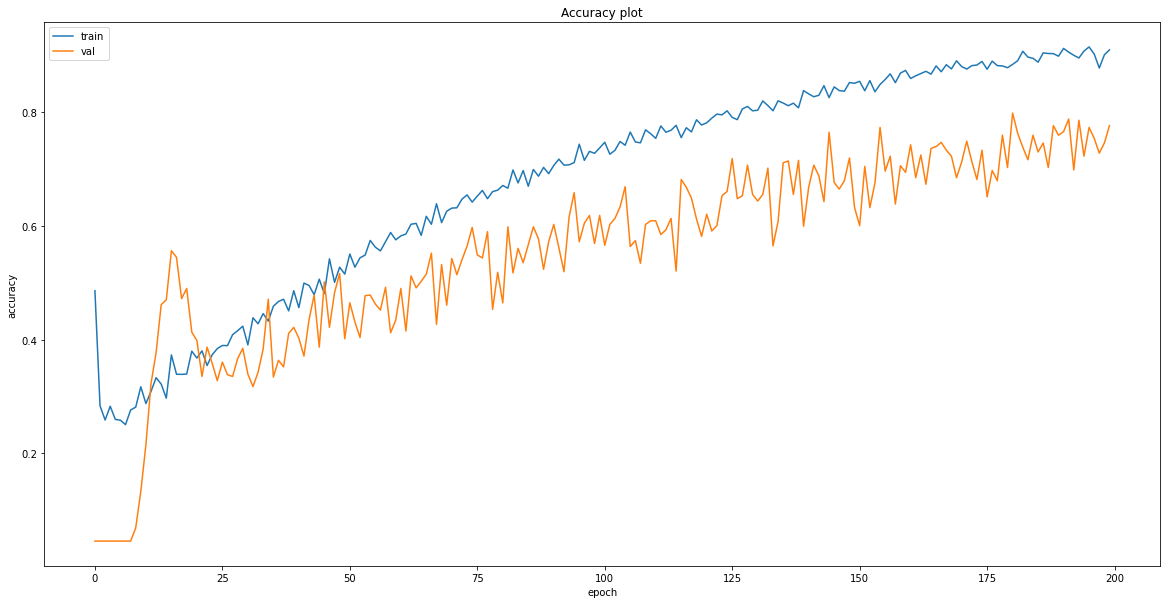

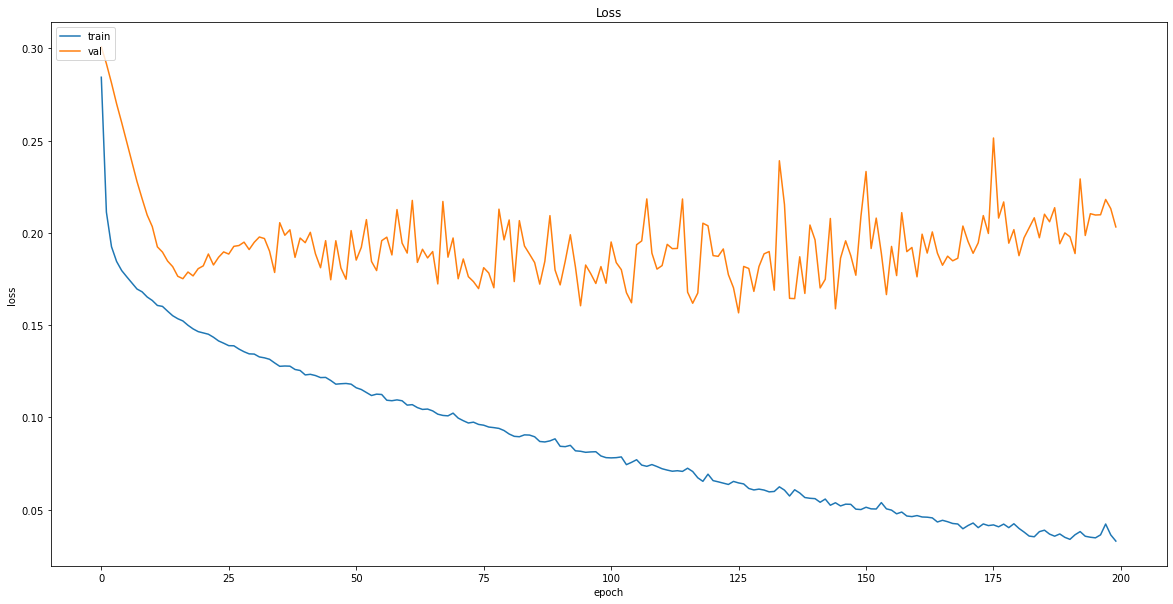

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
# Save model
model.save("models/{}".format('WMT_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/WMT_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [128]:
logger = []

In [129]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [130]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [131]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [132]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [133]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1494 - accuracy: 0.8532 - mean_squared_error: 8.0118 - weighted_accuracy: 0.8532 - weighted_mean_squared_error: 8.0118
Test loss: 0.149393692612648
Test accuracy: 0.853210985660553


In [134]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 0: 16, 1: 6})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [136]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [137]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


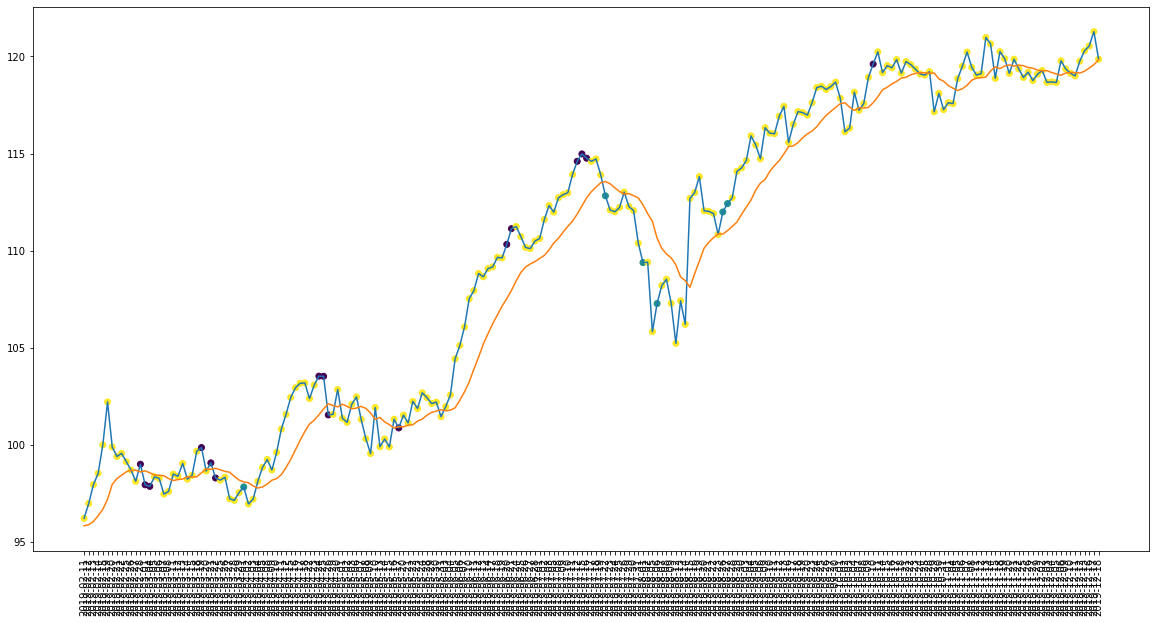

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

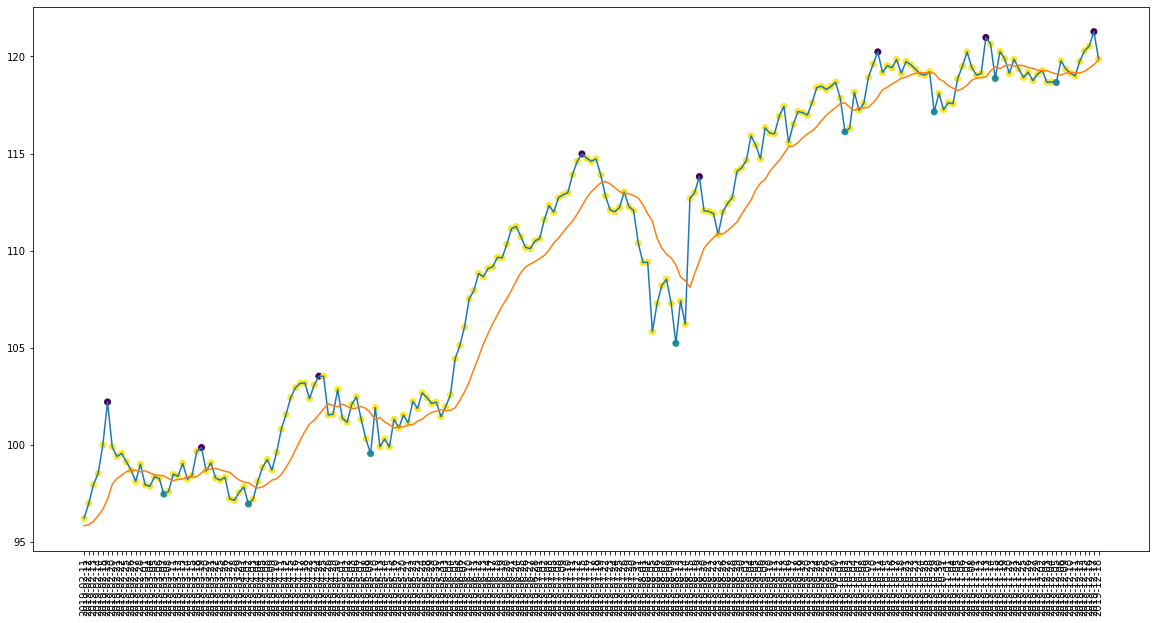

In [139]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [140]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 6
actual holds but predicted sell: 13
actual predicted holds: 183
Percentage buys correct: 0.0%
Percentage sells correct: 37.5%
Percentage holds correct: 90.5940594059406%
actual buys: 8
actual sells: 8
actual holds: 202


In [141]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 68.75%
Percentage holds correct: 85.64102564102564%


In [142]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $97.81999969482422
Shares owned at the moment: 101
Cash capital at the moment: $93.01052590751533


Price increase from previously bought: 5.546996936391113%
Share price: $103.52999877929688
Shares owned at the moment: 0
Cash capital at the moment: $10520.784945455549


Share price: $112.81999969482422
Shares owned at the moment: 92
Cash capital at the moment: $112.80151360893069


Stop Loss Activated!

Share price: $109.37999725341795
Shares owned at the moment: 0
Cash capital at the moment: $10148.088121618266


Share price: $109.37999725341795
Shares owned at the moment: 92
Cash capital at the moment: $57.45523499869887


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9766.122746999736


Share price: $107.2699966430664
Shares owned at the moment: 90
Cash capital at the moment: $85.27372495460077


Price increase from previously bought: 11.197892151999422%
Share price: $119.61000061035156
Shares owned at 

In [143]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [144]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%
2,0.782609,18.181818181818183%,30.0%,84.40860215053763%,60.0%,53.333333333333336%,79.53216374269006%,38.859174240198136%,24.380335833320625%
3,0.725962,14.285714285714286%,25.0%,76.6839378238342%,57.142857142857146%,59.25925925925926%,84.90566037735849%,45.92190177527426%,64.87407351390837%
4,0.853211,0.0%,37.5%,90.5940594059406%,66.66666666666667%,68.75%,85.64102564102564%,8.205703047351799%,23.7578138288879%


### Recession

In [145]:
logger = []

In [146]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [147]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [148]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [149]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [150]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.8082 - mean_squared_error: 9.8094 - weighted_accuracy: 0.8082 - weighted_mean_squared_error: 9.8094
Test loss: 0.2050458937883377
Test accuracy: 0.8082191944122314


In [151]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 192, 0: 19, 1: 8})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [153]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [154]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,0,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


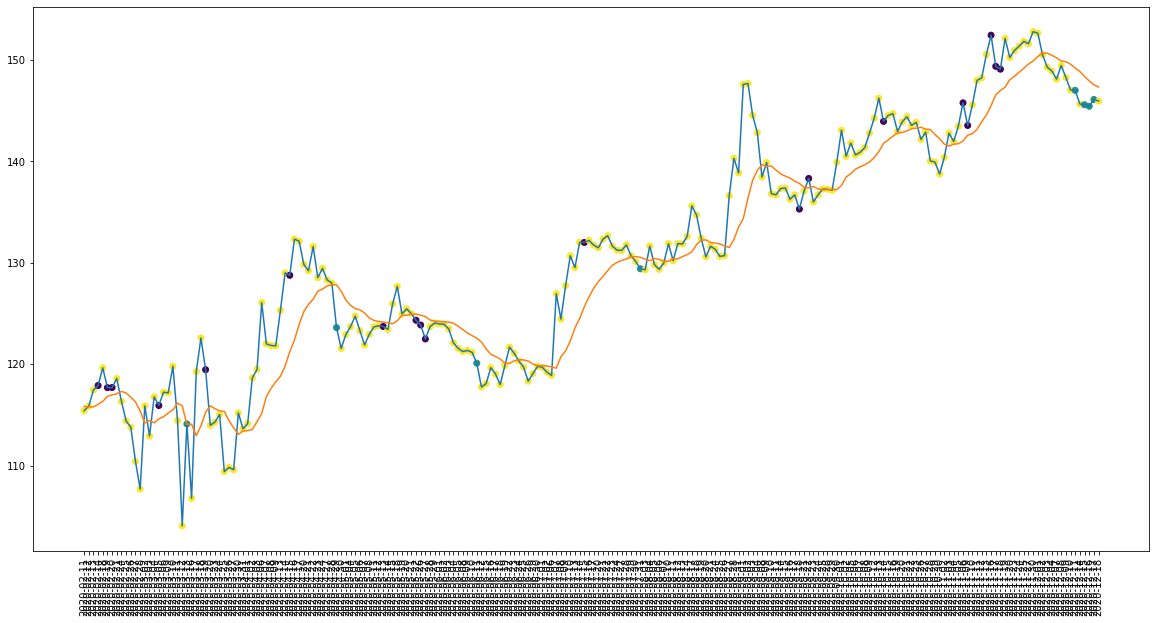

In [155]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

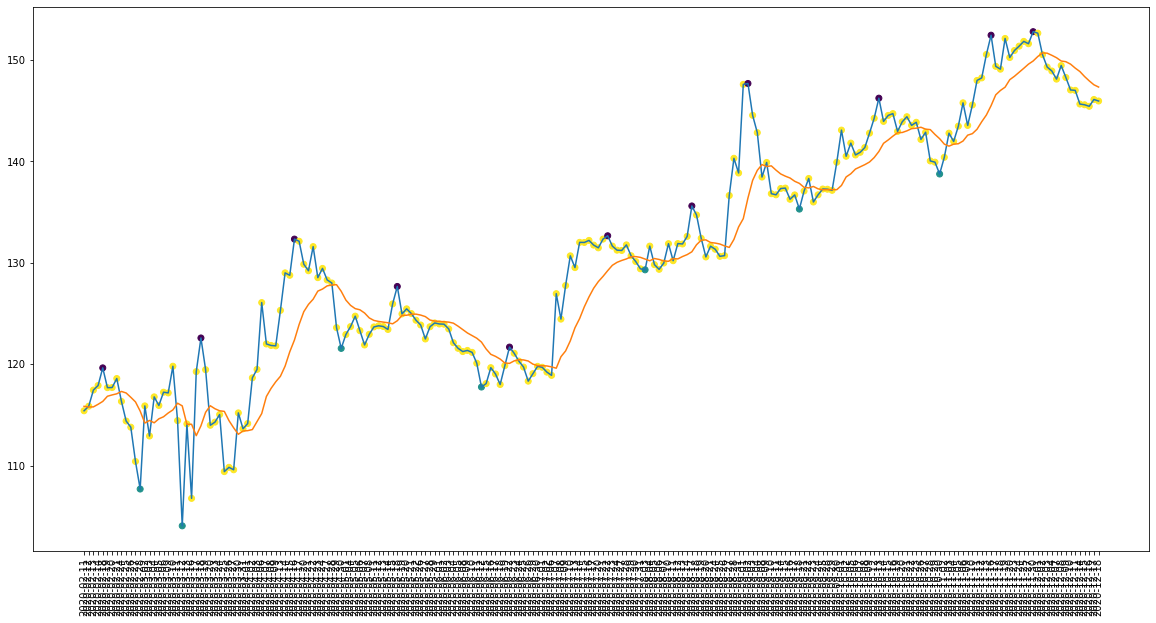

In [156]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [157]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 8
actual holds but predicted sell: 17
actual predicted holds: 176
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 87.56218905472637%
actual buys: 7
actual sells: 11
actual holds: 201


In [158]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 62.5%
Percentage sells correct: 36.8421052631579%
Percentage holds correct: 85.86387434554973%


In [159]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $114.0999984741211
Shares owned at the moment: 87
Cash capital at the moment: $46.00170811653152


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9308.579563457492


Share price: $123.5999984741211
Shares owned at the moment: 75
Cash capital at the moment: $13.08717821312166


Stop Loss Activated!

Share price: $120.08999633789062
Shares owned at the moment: 0
Cash capital at the moment: $8995.068341810229


Share price: $120.08999633789062
Shares owned at the moment: 74
Cash capital at the moment: $83.97029855156143


Price increase from previously bought: 9.616120848199916%
Share price: $132.0
Shares owned at the moment: 0
Cash capital at the moment: $9825.10829855156


Share price: $129.39999389648438
Shares owned at the moment: 75
Cash capital at the moment: $93.42000757408277


Price increase from previously bought: 6.592499746543101%
Share price: $138.30999755859378
Shares owned at the moment: 0
Cash 

In [160]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [161]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%
2,0.782609,18.181818181818183%,30.0%,84.40860215053763%,60.0%,53.333333333333336%,79.53216374269006%,38.859174240198136%,24.380335833320625%
3,0.725962,14.285714285714286%,25.0%,76.6839378238342%,57.142857142857146%,59.25925925925926%,84.90566037735849%,45.92190177527426%,64.87407351390837%
4,0.853211,0.0%,37.5%,90.5940594059406%,66.66666666666667%,68.75%,85.64102564102564%,8.205703047351799%,23.7578138288879%
5,0.808219,0.0%,9.090909090909092%,87.56218905472637%,62.5%,36.8421052631579%,85.86387434554973%,3.0825029943657136%,25.65490331684112%


## Fresh Del Monte Produce Inc

In [162]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


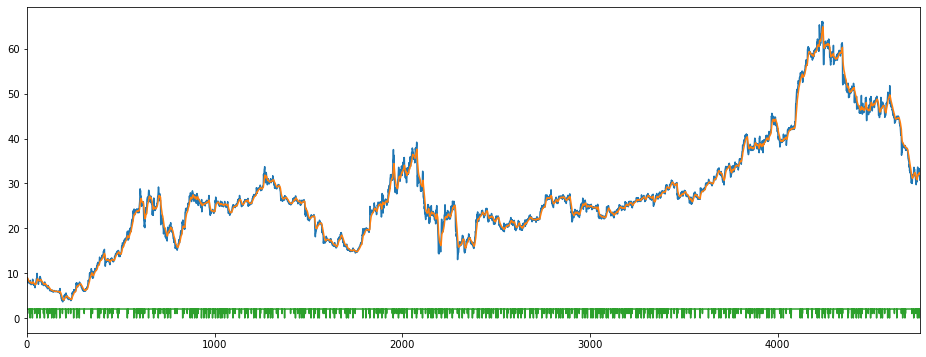

In [163]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [165]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [166]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2894 - accuracy: 0.4968 - mse: 0.4595 - weighted_accuracy: 0.3414 - weighted_mse: 0.5271 - val_loss: 0.3003 - val_accuracy: 0.0453 - val_mse: 0.3476 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3476
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2159 - accuracy: 0.3319 - mse: 0.7569 - weighted_accuracy: 0.4180 - weighted_mse: 0.7542 - val_loss: 0.2909 - val_accuracy: 0.0464 - val_mse: 0.3782 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3782
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1947 - accuracy: 0.3282 - mse: 0.9569 - weighted_accuracy: 0.4512 - weighted_mse: 0.9520 - val_loss: 0.2796 - val_accuracy: 0.0464 - val_mse: 0.4182 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4182
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1848 - accuracy: 0.3048 - mse: 1.1113 - weighted_accuracy: 0.4842 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1460 - accuracy: 0.3691 - mse: 1.5346 - weighted_accuracy: 0.6707 - weighted_mse: 1.4690 - val_loss: 0.1886 - val_accuracy: 0.3393 - val_mse: 1.6107 - val_weighted_accuracy: 0.3393 - val_weighted_mse: 1.6107
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1454 - accuracy: 0.4057 - mse: 1.5196 - weighted_accuracy: 0.6894 - weighted_mse: 1.4578 - val_loss: 0.1853 - val_accuracy: 0.3867 - val_mse: 1.5786 - val_weighted_accuracy: 0.3867 - val_weighted_mse: 1.5786
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1433 - accuracy: 0.4028 - mse: 1.5357 - weighted_accuracy: 0.6740 - weighted_mse: 1.4704 - val_loss: 0.1827 - val_accuracy: 0.3878 - val_mse: 1.5572 - val_weighted_accuracy: 0.3878 - val_weighted_mse: 1.5572
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1432 - accuracy: 0.4020 - mse: 1.5414 - weighted_accuracy: 0.6918 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1222 - accuracy: 0.5506 - mse: 1.7691 - weighted_accuracy: 0.7735 - weighted_mse: 1.7558 - val_loss: 0.1791 - val_accuracy: 0.5016 - val_mse: 1.7718 - val_weighted_accuracy: 0.5016 - val_weighted_mse: 1.7718
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1209 - accuracy: 0.5461 - mse: 1.7835 - weighted_accuracy: 0.7808 - weighted_mse: 1.7580 - val_loss: 0.1693 - val_accuracy: 0.5100 - val_mse: 1.8879 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 1.8879
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1198 - accuracy: 0.5377 - mse: 1.7841 - weighted_accuracy: 0.7832 - weighted_mse: 1.7453 - val_loss: 0.1775 - val_accuracy: 0.4879 - val_mse: 1.7981 - val_weighted_accuracy: 0.4879 - val_weighted_mse: 1.7981
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1195 - accuracy: 0.5545 - mse: 1.8127 - weighted_accuracy: 0.7803 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0976 - accuracy: 0.6575 - mse: 2.1643 - weighted_accuracy: 0.8489 - weighted_mse: 2.2030 - val_loss: 0.1905 - val_accuracy: 0.4773 - val_mse: 2.4042 - val_weighted_accuracy: 0.4773 - val_weighted_mse: 2.4042
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0984 - accuracy: 0.6654 - mse: 2.1858 - weighted_accuracy: 0.8518 - weighted_mse: 2.2249 - val_loss: 0.2119 - val_accuracy: 0.4447 - val_mse: 2.4834 - val_weighted_accuracy: 0.4447 - val_weighted_mse: 2.4834
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0991 - accuracy: 0.6631 - mse: 2.1853 - weighted_accuracy: 0.8420 - weighted_mse: 2.2347 - val_loss: 0.1697 - val_accuracy: 0.5680 - val_mse: 2.4125 - val_weighted_accuracy: 0.5680 - val_weighted_mse: 2.4125
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0971 - accuracy: 0.6794 - mse: 2.2196 - weighted_accuracy: 0.8624 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0769 - accuracy: 0.7742 - mse: 2.7289 - weighted_accuracy: 0.8954 - weighted_mse: 2.8096 - val_loss: 0.1830 - val_accuracy: 0.5911 - val_mse: 2.9978 - val_weighted_accuracy: 0.5911 - val_weighted_mse: 2.9978
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0766 - accuracy: 0.7524 - mse: 2.7844 - weighted_accuracy: 0.9000 - weighted_mse: 2.8571 - val_loss: 0.1751 - val_accuracy: 0.6344 - val_mse: 2.9909 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 2.9909
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0762 - accuracy: 0.7682 - mse: 2.8417 - weighted_accuracy: 0.9022 - weighted_mse: 2.9501 - val_loss: 0.1723 - val_accuracy: 0.6291 - val_mse: 3.1495 - val_weighted_accuracy: 0.6291 - val_weighted_mse: 3.1495
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0762 - accuracy: 0.7771 - mse: 2.8811 - weighted_accuracy: 0.9091 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.8385 - mse: 3.7196 - weighted_accuracy: 0.9353 - weighted_mse: 3.7701 - val_loss: 0.1755 - val_accuracy: 0.6849 - val_mse: 4.1999 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 4.1999
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.8314 - mse: 3.7123 - weighted_accuracy: 0.9309 - weighted_mse: 3.7697 - val_loss: 0.1591 - val_accuracy: 0.7302 - val_mse: 4.0693 - val_weighted_accuracy: 0.7302 - val_weighted_mse: 4.0693
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.8359 - mse: 3.7588 - weighted_accuracy: 0.9325 - weighted_mse: 3.7987 - val_loss: 0.1779 - val_accuracy: 0.6934 - val_mse: 4.3195 - val_weighted_accuracy: 0.6934 - val_weighted_mse: 4.3195
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0568 - accuracy: 0.8380 - mse: 3.8897 - weighted_accuracy: 0.9333 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0465 - accuracy: 0.8788 - mse: 4.9385 - weighted_accuracy: 0.9537 - weighted_mse: 4.7911 - val_loss: 0.1825 - val_accuracy: 0.7334 - val_mse: 5.3434 - val_weighted_accuracy: 0.7334 - val_weighted_mse: 5.3434
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 0.8788 - mse: 4.8698 - weighted_accuracy: 0.9519 - weighted_mse: 4.8480 - val_loss: 0.1918 - val_accuracy: 0.6955 - val_mse: 5.0618 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 5.0618
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0439 - accuracy: 0.8975 - mse: 5.0461 - weighted_accuracy: 0.9606 - weighted_mse: 4.9177 - val_loss: 0.1685 - val_accuracy: 0.7492 - val_mse: 5.3525 - val_weighted_accuracy: 0.7492 - val_weighted_mse: 5.3525
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8928 - mse: 5.0525 - weighted_accuracy: 0.9588 - 

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.19303978979587555
Test accuracy: 0.7839831113815308


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.054921   -2.495711    1.5461912 ]
 [-0.9039618  -2.6046026   0.2975159 ]
 [-1.7066557  -2.1030977   0.26869774]
 ...
 [-0.22441195 -5.018893   -0.3376501 ]
 [-2.5057266  -3.4325905   1.8392704 ]
 [ 0.14548032 -2.4767373  -0.79393595]]


Counter({2: 821, 0: 72, 1: 56})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 41
actual holds but predicted buy: 53
actual holds but predicted sell: 70
actual predicted holds: 739
Percentage buys correct: 6.818181818181818%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 85.7308584686775%
actual buys: 44
actual sells: 43
actual holds: 862


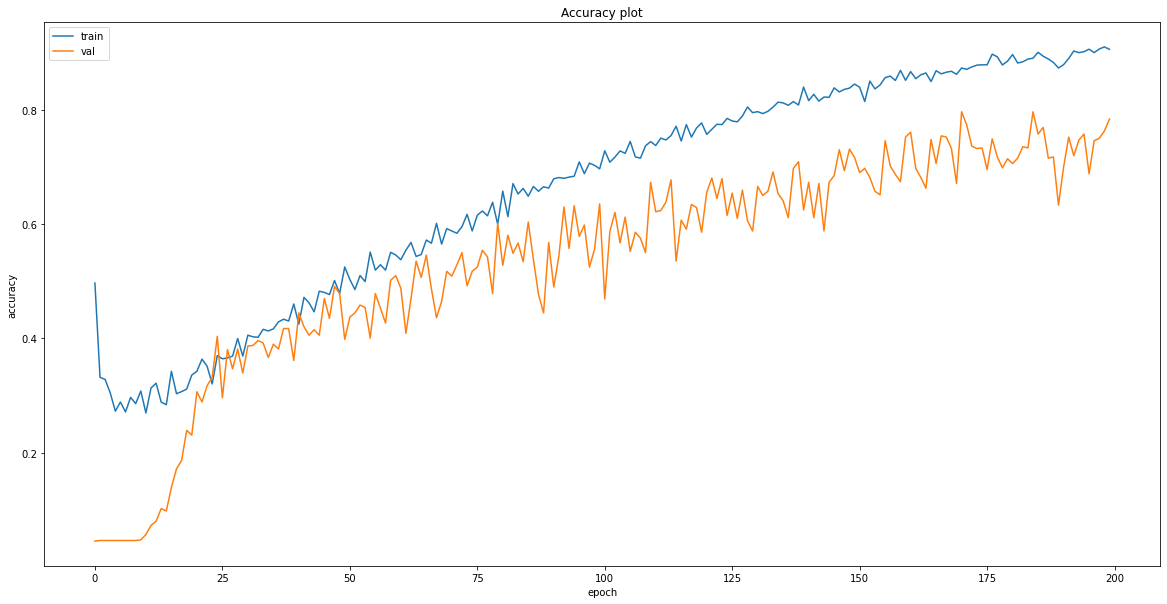

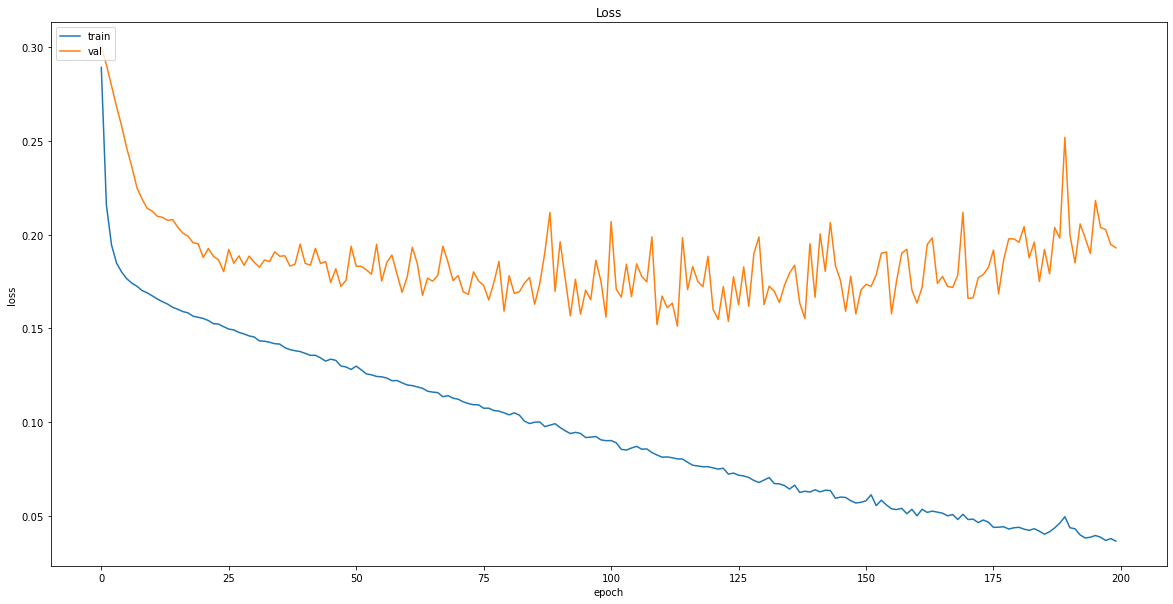

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [178]:
logger = []

In [179]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [180]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [182]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [183]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1901 - accuracy: 0.7982 - mean_squared_error: 7.4506 - weighted_accuracy: 0.7982 - weighted_mean_squared_error: 7.4506
Test loss: 0.19011777639389038
Test accuracy: 0.7981651425361633


In [184]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 11, 2: 188, 1: 19})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [186]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [187]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,0,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


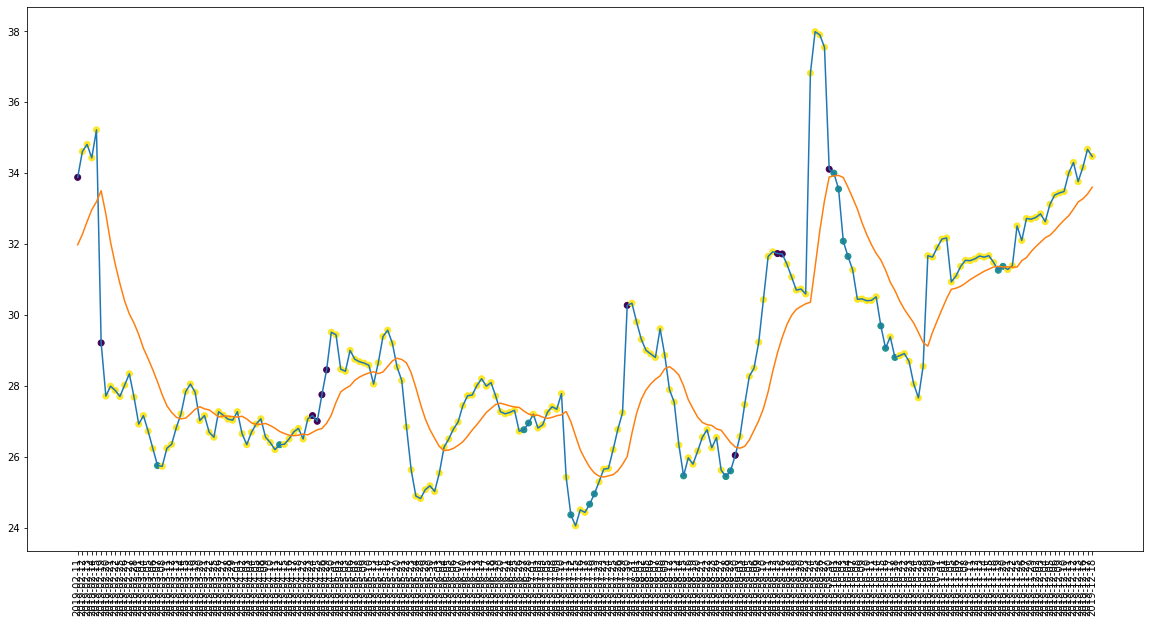

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

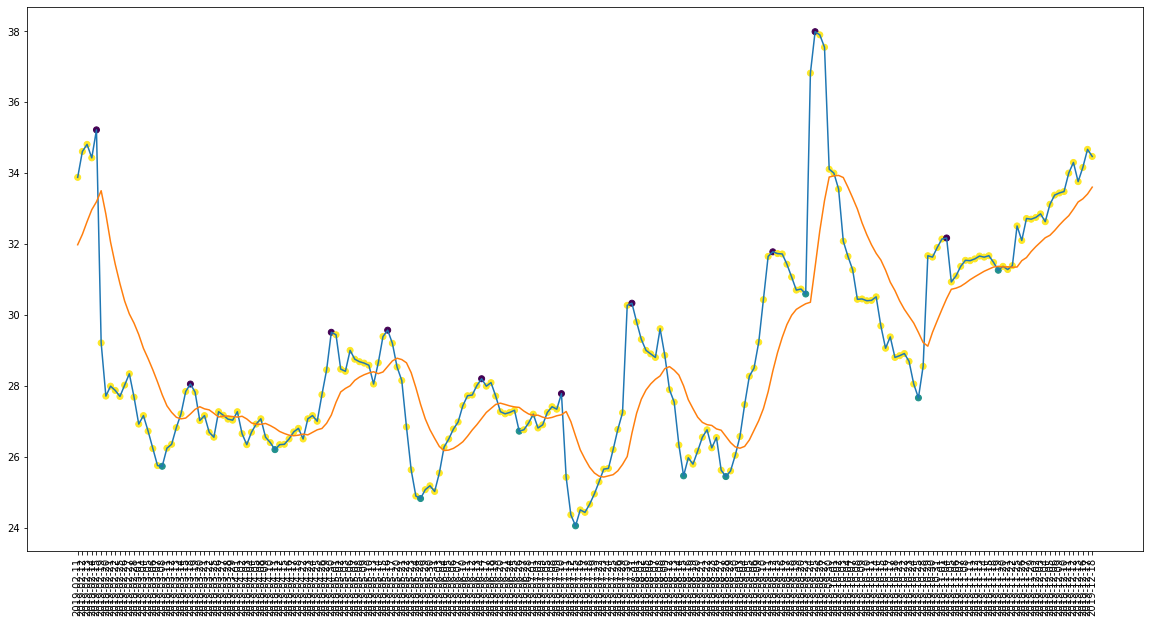

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [190]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 11
actual predicted holds: 171
Percentage buys correct: 30.0%
Percentage sells correct: 0.0%
Percentage holds correct: 86.36363636363636%
actual buys: 10
actual sells: 10
actual holds: 198


In [191]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 57.89473684210526%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 82.88770053475936%


In [192]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $25.75
Shares owned at the moment: 387
Cash capital at the moment: $7.345562500000597


Price increase from previously bought: 5.186464784607803%
Share price: $27.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10489.36047361088


Share price: $26.76000022888184
Shares owned at the moment: 390
Cash capital at the moment: $24.260284101485013


Stop Loss Activated!

Share price: $25.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9910.797363774298


Share price: $24.36000061035156
Shares owned at the moment: 405
Cash capital at the moment: $17.866165902138164


Price increase from previously bought: 23.920301679962286%
Share price: $30.270000457763672
Shares owned at the moment: 0
Cash capital at the moment: $12243.503138286591


Share price: $25.459999084472656
Shares owned at the moment: 479
Cash capital at the moment: $14.626393030166582


Price increase from previously bought: 24.285084373156018%
Share price: $31.72999

In [193]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [194]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%
2,0.782609,18.181818181818183%,30.0%,84.40860215053763%,60.0%,53.333333333333336%,79.53216374269006%,38.859174240198136%,24.380335833320625%
3,0.725962,14.285714285714286%,25.0%,76.6839378238342%,57.142857142857146%,59.25925925925926%,84.90566037735849%,45.92190177527426%,64.87407351390837%
4,0.853211,0.0%,37.5%,90.5940594059406%,66.66666666666667%,68.75%,85.64102564102564%,8.205703047351799%,23.7578138288879%
5,0.808219,0.0%,9.090909090909092%,87.56218905472637%,62.5%,36.8421052631579%,85.86387434554973%,3.0825029943657136%,25.65490331684112%
6,0.798165,30.0%,0.0%,86.36363636363636%,57.89473684210526%,45.45454545454545%,82.88770053475936%,35.798032515678315%,1.1819906801032993%


### recession

In [195]:
logger = []

In [196]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [197]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [198]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1935 - accuracy: 0.7945 - mean_squared_error: 7.0009 - weighted_accuracy: 0.7945 - weighted_mean_squared_error: 7.0009
Test loss: 0.19345958530902863
Test accuracy: 0.7945205569267273


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 188, 1: 15, 0: 16})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [204]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


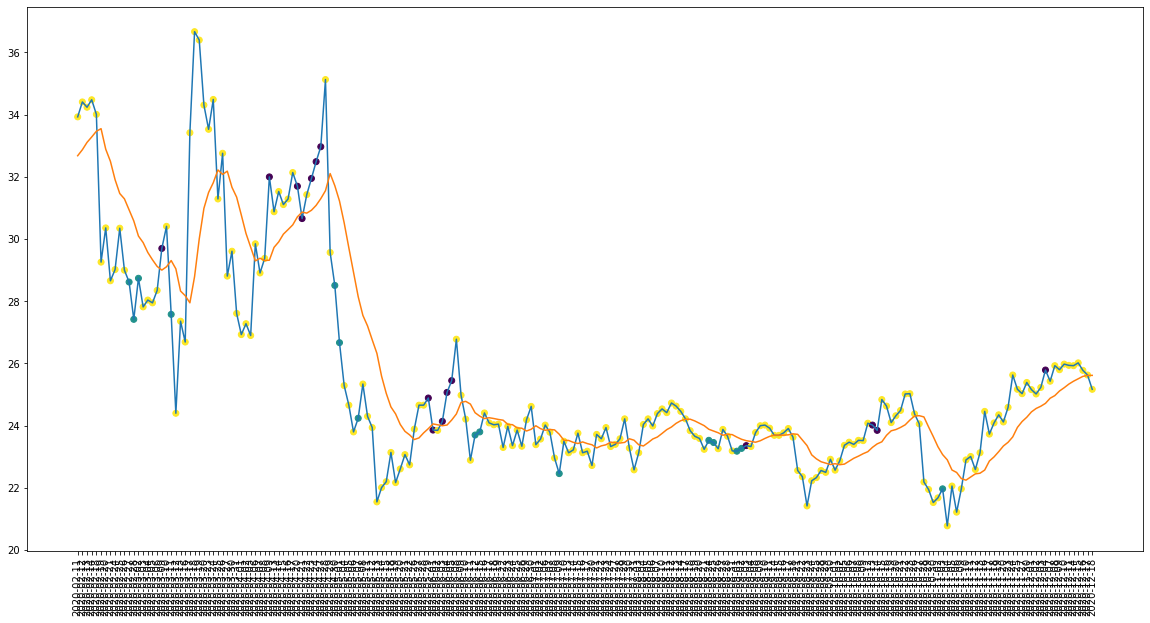

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

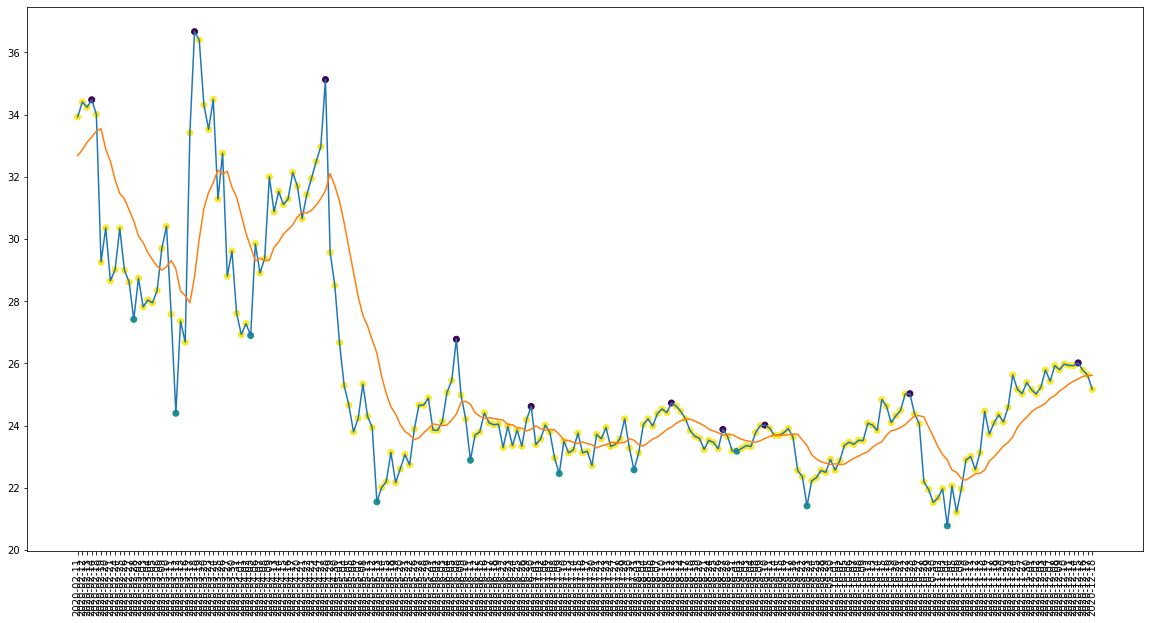

In [206]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [207]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 12
actual holds but predicted sell: 16
actual predicted holds: 171
Percentage buys correct: 30.0%
Percentage sells correct: 0.0%
Percentage holds correct: 85.92964824120602%
actual buys: 10
actual sells: 10
actual holds: 199


In [208]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 73.33333333333333%
Percentage sells correct: 56.25%
Percentage holds correct: 82.3529411764706%


In [209]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.6200008392334
Shares owned at the moment: 348
Cash capital at the moment: $12.850367143630137


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9528.76945362091


Share price: $27.420000076293945
Shares owned at the moment: 346
Cash capital at the moment: $15.359297150609564


Price increase from previously bought: 8.018051308215268%
Share price: $29.70000076293945
Shares owned at the moment: 0
Cash capital at the moment: $10263.300010401721


Share price: $27.57999992370605
Shares owned at the moment: 371
Cash capital at the moment: $2.9815437846154964


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9030.487302648542


Share price: $28.51000022888184
Shares owned at the moment: 315
Cash capital at the moment: $25.140442852492924


Stop Loss Activated!

Share price: $26.670000076293945
Shares owned at the moment: 0
Cash capital at the mo

In [210]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [211]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.792271,27.272727272727273%,27.272727272727273%,85.4054054054054%,71.42857142857143%,47.36842105263158%,86.7816091954023%,35.87250678344724%,55.56771999603271%
1,0.812500,11.11111111111111%,10.0%,88.35978835978835%,100.0%,50.0%,85.24590163934427%,42.237442109069775%,67.54069125000002%
2,0.782609,18.181818181818183%,30.0%,84.40860215053763%,60.0%,53.333333333333336%,79.53216374269006%,38.859174240198136%,24.380335833320625%
3,0.725962,14.285714285714286%,25.0%,76.6839378238342%,57.142857142857146%,59.25925925925926%,84.90566037735849%,45.92190177527426%,64.87407351390837%
4,0.853211,0.0%,37.5%,90.5940594059406%,66.66666666666667%,68.75%,85.64102564102564%,8.205703047351799%,23.7578138288879%
5,0.808219,0.0%,9.090909090909092%,87.56218905472637%,62.5%,36.8421052631579%,85.86387434554973%,3.0825029943657136%,25.65490331684112%
6,0.798165,30.0%,0.0%,86.36363636363636%,57.89473684210526%,45.45454545454545%,82.88770053475936%,35.798032515678315%,1.1819906801032993%
7,0.794521,30.0%,0.0%,85.92964824120602%,73.33333333333333%,56.25%,82.3529411764706%,-39.746083890786224%,-26.14299892369747%


In [212]:
experiment

'No EMA LSTM Time Series - noncyclic'

In [213]:
log.to_csv('{}.csv'.format(experiment))